In [1]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from yahoofinancials import YahooFinancials
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

In [2]:
ticker_details = pd.read_excel("Ticker List.xlsx")
ticker_details.head(20)

,Ticker,Description
0,GC=F,Gold
1,SI=F,Silver
2,CL=F,Crude Oil
3,^GSPC,S&P500
4,^RUT,Russel 2000 Index
5,ZN=F,10 Yr US T-Note futures
6,ZT=F,2 Yr US T-Note Futures
7,PL=F,Platinum
8,HG=F,Copper
9,DX=F,Dollar Index


In [3]:
ticker = ticker_details['Ticker'].to_list()
names = ticker_details['Description'].to_list()

In [4]:
# Extracting Data from Yahoo Finance and Adding them to Values table using date as key
end_date= "2020-09-30"
start_date = "2010-01-01"
date_range = pd.bdate_range(start=start_date,end=end_date)
"""
Create a date-range and write it to an empty dataframe named values. Here I would extract and 
past the values pulled from yahoofinancials.
"""
df = pd.DataFrame({ 'Date': date_range})
df['Date']= pd.to_datetime(df['Date'])

In [5]:
from pandas import DataFrame 
#Extracting Data from Yahoo Finance and Adding them to Values table using date as key
for i in ticker:
    raw_data = YahooFinancials(i)
    raw_data = raw_data.get_historical_price_data(start_date, end_date, "daily")
    data = DataFrame(raw_data[i]['prices'])[['formatted_date','adjclose']]
    data.columns = ['Date1',i]
    data['Date1']= pd.to_datetime(data['Date1'])
    df = df.merge(data,how='left',left_on='Date',right_on='Date1')
    df = df.drop(labels='Date1',axis=1)

#Renaming columns to represent instrument names rather than their ticker codes for ease of readability
names.insert(0,'Date')
df.columns = names
print(df.shape)
print(df.isna().sum())
df.tail()

(2804, 17)
Date                         0
Gold                       122
Silver                     122
Crude Oil                  121
S&P500                     100
Russel 2000 Index          100
10 Yr US T-Note futures    123
2 Yr US T-Note Futures     121
Platinum                   122
Copper                     122
Dollar Index               123
Volatility Index           100
Soybean                    147
MSCI EM ETF                100
Euro USD                   338
Euronext100                 59
Nasdaq                     100
dtype: int64


,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2799,2020-09-24,1868.300049,23.118000,40.310001,3246.590088,1451.819946,139.578003,110.426003,837.099976,2.9690,94.393997,28.510000,NaN,42.900002,1.167324,948.109985,10672.269531
2800,2020-09-25,1857.699951,23.017000,40.250000,3298.459961,1474.910034,139.641006,110.438004,841.099976,2.9730,94.681999,26.379999,NaN,42.939999,NaN,944.549988,10913.559570
2801,2020-09-28,1872.800049,23.528000,40.599998,3351.600098,1510.339966,139.625000,110.441002,881.900024,2.9895,94.302002,26.190001,NaN,43.419998,1.167883,965.710022,11117.530273
2802,2020-09-29,1894.300049,24.379999,39.290001,3335.469971,1504.729980,139.781006,110.445000,887.500000,2.9835,93.927002,26.270000,NaN,43.389999,1.174205,962.190002,11085.250000
2803,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Front filling the NaN values in the data set
df = df.fillna(method="ffill",axis=0)
df = df.fillna(method="bfill",axis=0)
df.isna().sum()

Date                       0
Gold                       0
Silver                     0
Crude Oil                  0
S&P500                     0
Russel 2000 Index          0
10 Yr US T-Note futures    0
2 Yr US T-Note Futures     0
Platinum                   0
Copper                     0
Dollar Index               0
Volatility Index           0
Soybean                    0
MSCI EM ETF                0
Euro USD                   0
Euronext100                0
Nasdaq                     0
dtype: int64

In [7]:
df.tail()

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2799,2020-09-24,1868.300049,23.118000,40.310001,3246.590088,1451.819946,139.578003,110.426003,837.099976,2.9690,94.393997,28.510000,903.75,42.900002,1.167324,948.109985,10672.269531
2800,2020-09-25,1857.699951,23.017000,40.250000,3298.459961,1474.910034,139.641006,110.438004,841.099976,2.9730,94.681999,26.379999,903.75,42.939999,1.167324,944.549988,10913.559570
2801,2020-09-28,1872.800049,23.528000,40.599998,3351.600098,1510.339966,139.625000,110.441002,881.900024,2.9895,94.302002,26.190001,903.75,43.419998,1.167883,965.710022,11117.530273
2802,2020-09-29,1894.300049,24.379999,39.290001,3335.469971,1504.729980,139.781006,110.445000,887.500000,2.9835,93.927002,26.270000,903.75,43.389999,1.174205,962.190002,11085.250000
2803,2020-09-30,1894.300049,24.379999,39.290001,3335.469971,1504.729980,139.781006,110.445000,887.500000,2.9835,93.927002,26.270000,903.75,43.389999,1.174205,962.190002,11085.250000


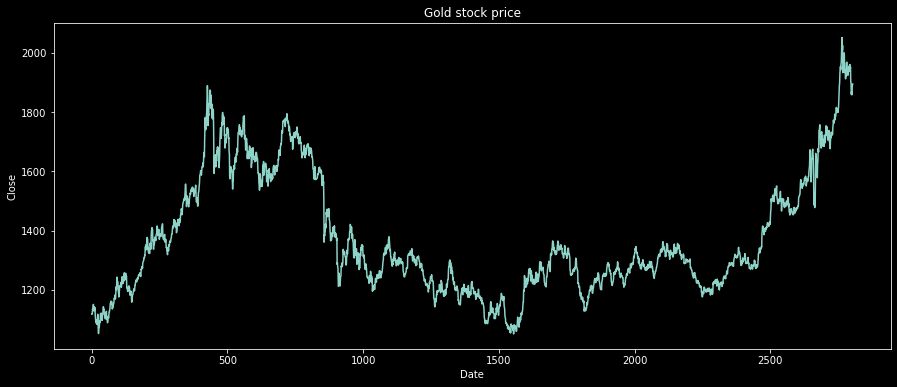

In [9]:
plt.style.use('dark_background')
df["Gold"].plot(figsize=(15, 6))
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Gold stock price")
plt.show()

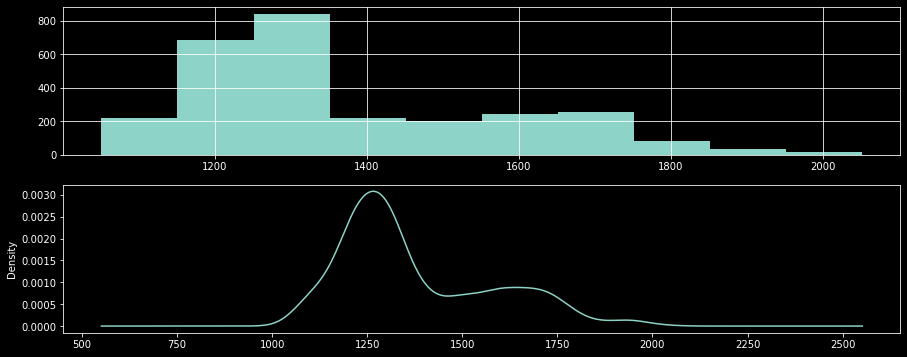

In [10]:
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Gold"].hist()
plt.subplot(212)
df["Gold"].plot(kind='kde')
plt.show()

In [21]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [12]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [13]:
Augmented_Dickey_Fuller_Test_func(df['Gold' ],'Gold')

Results of Dickey-Fuller Test for column: Gold
Test Statistic                   -1.253872
p-value                           0.650003
No Lags Used                      0.000000
Number of Observations Used    2803.000000
Critical Value (1%)              -3.432685
dtype: float64
Test Statistic                   -1.253872
p-value                           0.650003
No Lags Used                      0.000000
Number of Observations Used    2803.000000
Critical Value (1%)              -3.432685
Critical Value (5%)              -2.862572
dtype: float64
Test Statistic                   -1.253872
p-value                           0.650003
No Lags Used                      0.000000
Number of Observations Used    2803.000000
Critical Value (1%)              -3.432685
Critical Value (5%)              -2.862572
Critical Value (10%)             -2.567319
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


We can see that Gold is nonstationary, and auto-arima handles this
internally.

Model training will be done only for the Gold column from the
dataset. Make a copy of the data, and let’s perform the test/train split.
The train will have all the data except the last 30 days, and the test will
contain only the last 30 days to evaluate against predictions.

In [14]:
X = df[['Gold' ]]
train, test = X[0:-30], X[-30:]

In [15]:
stepwise_model = auto_arima(train,start_p=1, start_q=1,
                            max_p=7, max_q=7, seasonal=False,
                            d=None, trace=True,error_action='ignore',
                            suppress_warnings=True, stepwise=True)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22727.336, Time=5.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22724.464, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22725.482, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22725.504, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22723.668, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 8.927 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2774
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -11360.834
Date:                Mon, 26 Oct 2020   AIC                          22723.668
Time:                        12:58:23   BIC                          22729.596
Sample:                             0   HQIC                         22725.809
                               - 2774                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       211.8799      2.398     88.352      0.000     207.180     216.580
===================================================================================
Ljung-Box (Q):                       42.10   Jarque-Bera (JB):             10341.36
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto-arima says ARIMA(0,1,0) is the optimal selection for the dataset.

We will Forecast both results and the confidence for the next 30 days and store
it in a DataFrame

In [16]:
test

,Gold
2774,1933.800049
2775,1934.599976
2776,1927.699951
2777,1911.800049
2778,1940.699951
2779,1921.599976
2780,1964.599976
2781,1967.599976
2782,1968.199951
2783,1934.400024


In [22]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
df_conf["new_index"] = range(2773, 2803)
df_conf = df_conf.set_index("new_index")
timeseries_evaluation_metrics_func(test, forecast)

Evaluation metric results:-
MSE is : 2090.6110652705033
MSE is : 35.123291015625
RMSE is : 45.72320051429584
MAPE is : 1.8495032259614426
R2 is : -1.1445872552973433



In [23]:
# Rearrange the indexes for the plots to align, as shown here:
forecast["new_index"] = range(2773, 2803)
forecast = forecast.set_index("new_index")

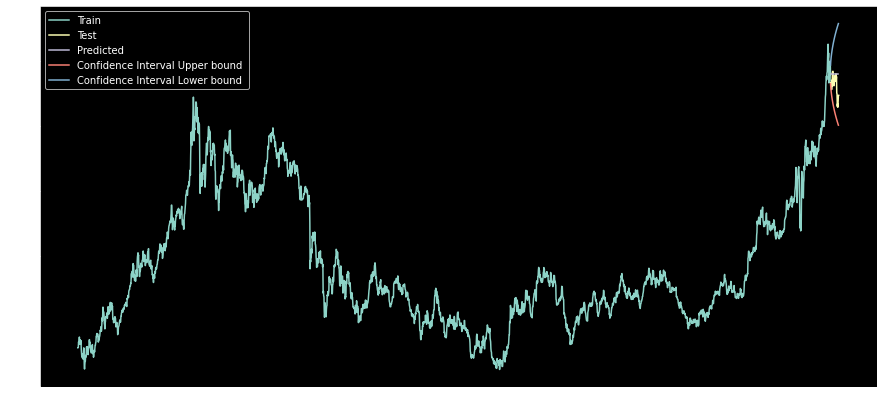

In [24]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()

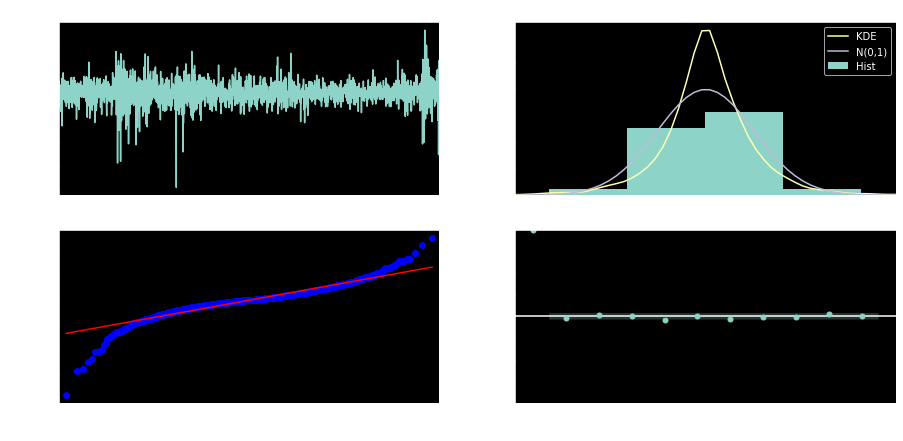

In [26]:
stepwise_model.plot_diagnostics();

# Seasonal ARIMA
The seasonal ARIMA model combines both nonseasonal and seasonal
components in a multiplicative model. The notation can be defined as follows:
- ARIMA (p, d, q) X (P, D, Q)m
- m is the number of observations per year.

Three trend elements need to be configured. It is same as the ARIMA
model, as shown here:
- (p, d, q) is a nonseasonal component, as shown here:
  - p: Trend autoregressive order
  - d: Trend differencing order
  - q: Trend moving average order

(P, Q, D) is a seasonal component.

There are four seasonal components that are not part of the ARIMA
model that are essential to be configured.
- P: Seasonal autoregressive order
- D: Seasonal differencing order
- Q: Seasonal moving average order
- m: Timestamp for single-season order


Let’s configure and run seasonal arima for the parameters given in the
for loop and check the optimal number of periods in each season suitable
for our dataset.
Here is the search space:
- p → 1 to 7.
- q → 1 to 7.
- d → None means find the optimal value.
- P → 1 to 7.
- Q → 1 to 7.
- D → None means find the optimal value.

m refers to the number of periods in each season.

- 7 → Daily
- 12 → Monthly
- 52 → Weekly
- 4 → Quarterly
- 1 → Annual (non-seasonal)

 Fitting SARIMA for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22727.336, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22724.464, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22725.482, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22725.504, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22723.668, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.487 seconds
Model summary for m = 1
----------------------------------------------------------------------------------------------------
Evaluation metric results:-
MSE is : 2090.6110652705033
MSE is : 35.123291015625
RMSE is : 45.72320051429584
MAPE is : 1.8495032259614426
R2 is : -1.1445872552973433



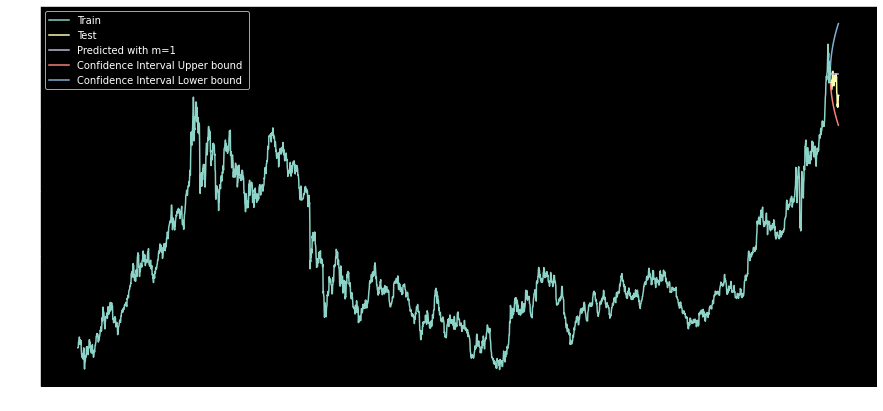

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 1


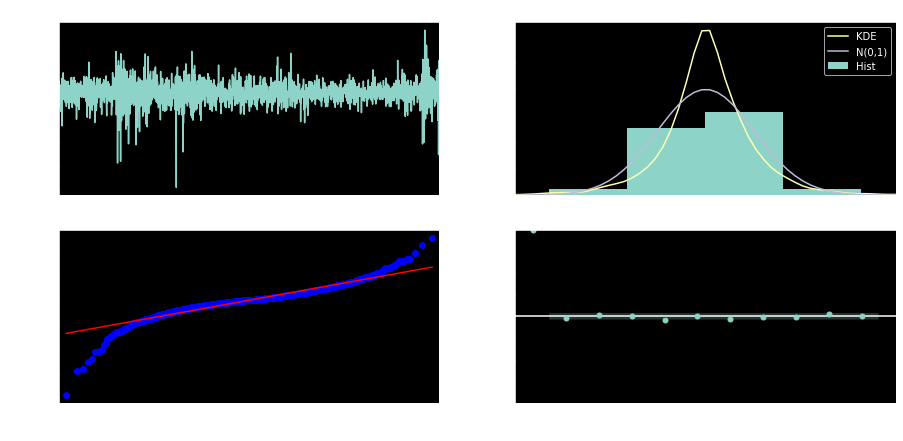

----------------------------------------------------------------------------------------------------
 Fitting SARIMA for Seasonal value m = 4
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=22725.057, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=22724.464, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=22721.365, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=22721.328, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=22723.668, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=22725.504, Time=0.31 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=22723.267, Time=1.63 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=22723.286, Time=1.38 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=22721.386, Time=0.83 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=22725.287, Time=2.36 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=22720.271, Time=0.58 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=22722.185, Time=1.08 sec
 ARIMA(0,1,

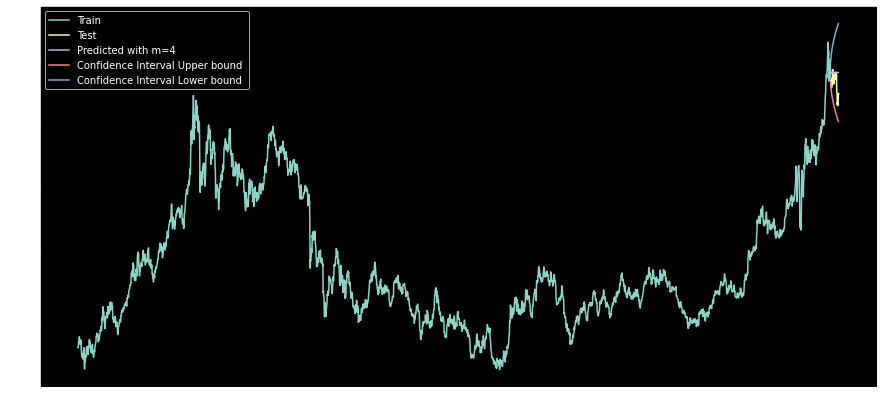

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 4


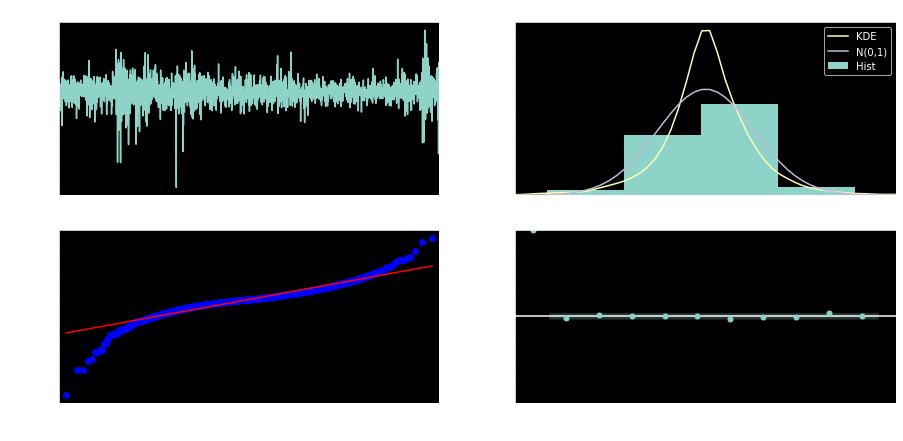

----------------------------------------------------------------------------------------------------
 Fitting SARIMA for Seasonal value m = 7
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=22729.331, Time=6.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=22724.464, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=22727.253, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=22727.268, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=22723.668, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=22726.277, Time=0.38 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=22726.269, Time=0.54 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=22726.604, Time=1.86 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=22725.482, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=22725.504, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=22727.336, Time=1.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 12.606 seconds


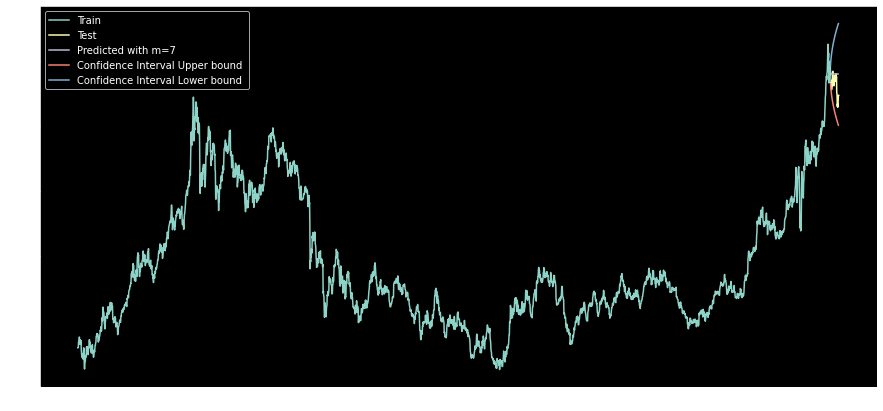

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 7


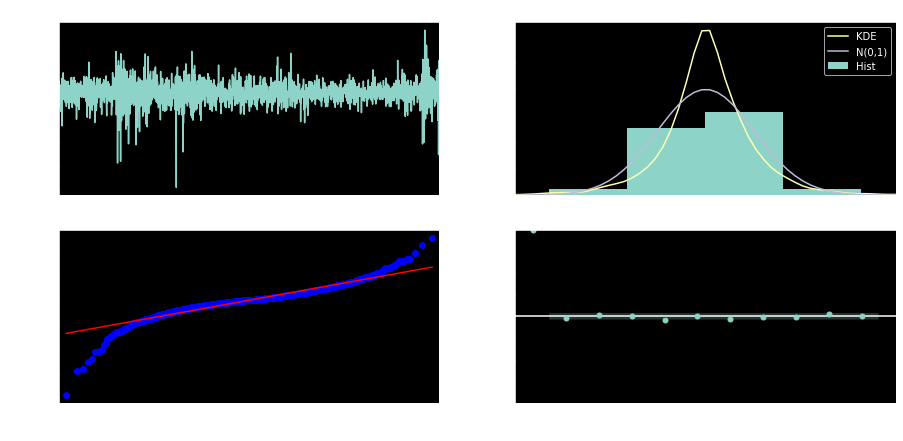

----------------------------------------------------------------------------------------------------
 Fitting SARIMA for Seasonal value m = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=22731.336, Time=3.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22724.464, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=22727.481, Time=0.50 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=22727.505, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22723.668, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=22726.459, Time=0.37 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=22726.459, Time=0.77 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=22728.464, Time=0.90 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=22725.482, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=22725.504, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=22727.336, Time=1.47 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 8.

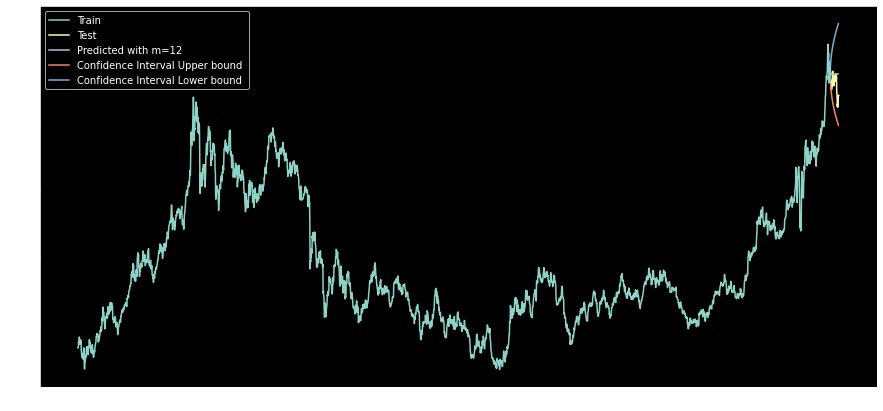

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 12


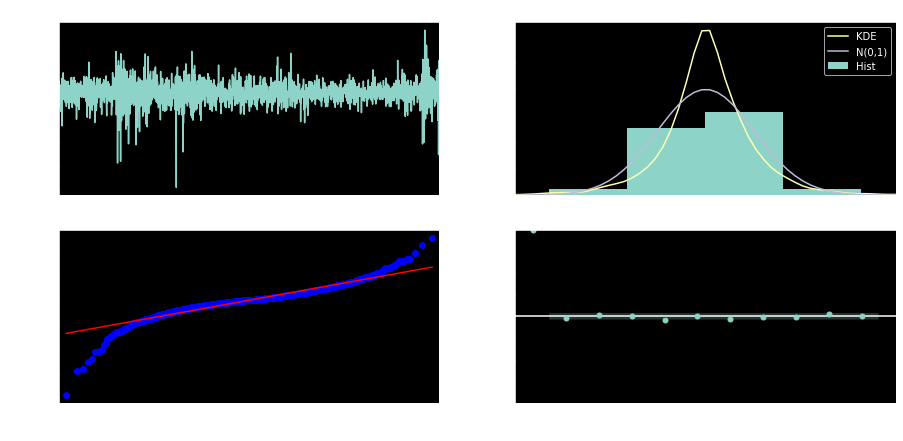

----------------------------------------------------------------------------------------------------
 Fitting SARIMA for Seasonal value m = 52
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=22729.820, Time=93.78 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=22724.464, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=22727.303, Time=7.05 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=22727.340, Time=7.44 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=22723.668, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=22726.309, Time=5.73 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=22726.320, Time=7.40 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=22726.991, Time=27.84 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=22725.482, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=22725.504, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=22727.336, Time=0.97 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
Total fit time: 

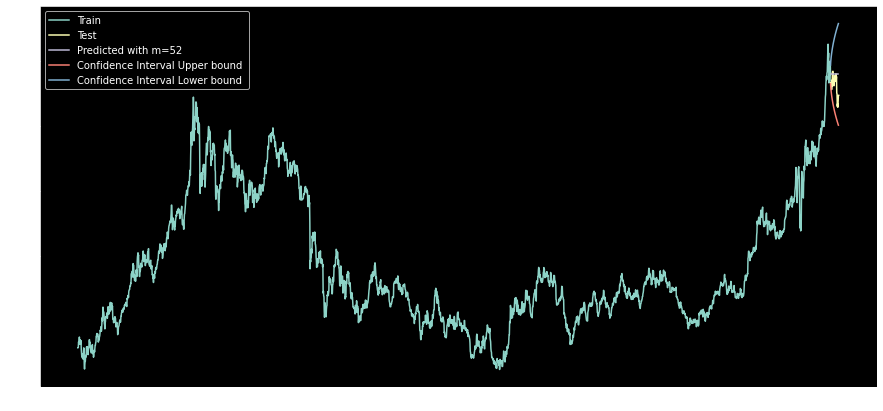

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 52


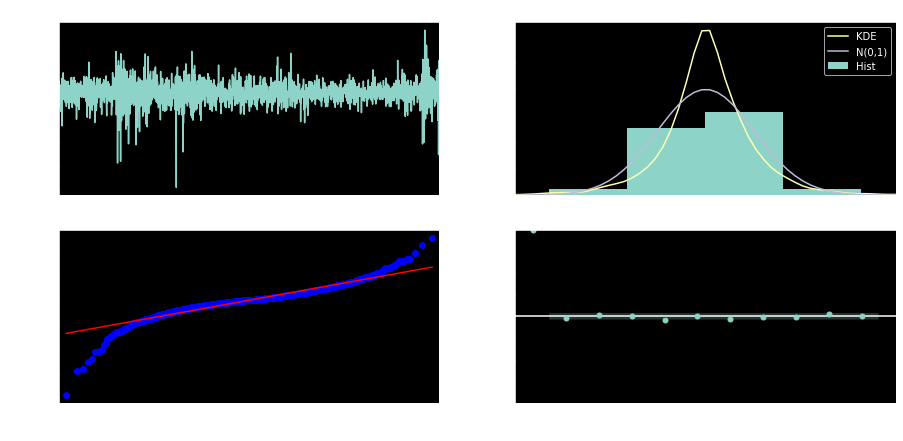

----------------------------------------------------------------------------------------------------


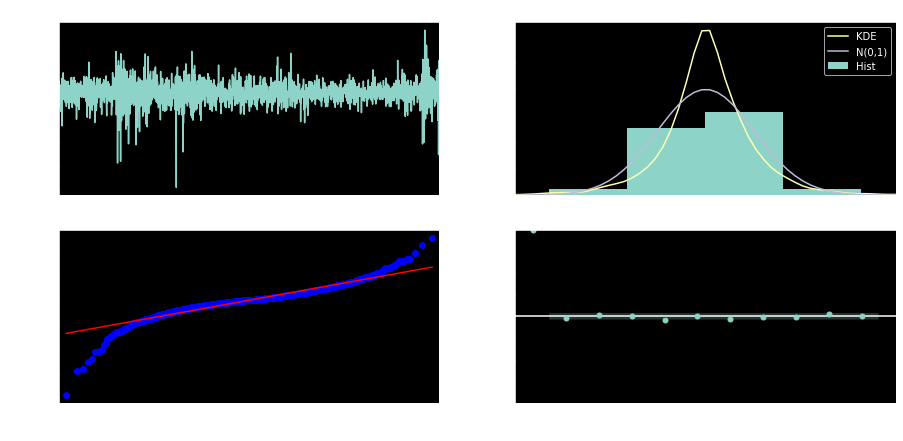

In [28]:
for m in [1, 4,7,12,52]:
    print("="*100)
    print(f' Fitting SARIMA for Seasonal value m = {str(m)}')
    
    stepwise_model = auto_arima(train, start_p=1, start_q=1,
                                max_p=7, max_q=7, seasonal=True, start_P=1,
                                start_Q=1, max_P=7, max_D=7, max_Q=7, m=m,
                                d=None, D=None, trace=True, error_action='ignore', 
                                suppress_warnings=True,
                                stepwise=True)
    
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    
    forecast ,conf_int= stepwise_model.predict(n_periods=30,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
    df_conf["new_index"] = range(2773, 2803)
    df_conf = df_conf.set_index("new_index")
    forecast = pd.DataFrame(forecast, columns=['close_pred'])
    forecast["new_index"] = range(2773, 2803)
    forecast = forecast.set_index("new_index")
    timeseries_evaluation_metrics_func(test, forecast)
    
    get_ipython().run_line_magic('matplotlib', 'inline')
    plt.rcParams["figure.figsize"] = [15, 7]
    plt.plot(train, label='Train ')
    plt.plot(test, label='Test ')
    plt.plot(forecast, label=f'Predicted with m={str(m)} ')
    plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
    plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
    plt.legend(loc='best')
    plt.show()
    print("-"*100)
    print(f' Diagnostic plot for Seasonal value m = {str(m)}')
    display(stepwise_model.plot_diagnostics());
    print("-"*100)

After checking for different m values, we can see that m does not have
any influence on the results.

## SARIMAX
SARIMAX model is SARIMA model with external influencing variables, called SARIMAX (p, d, q) X(P,D,Q)m (X), where X is the vector of exogenous variables. The exogenous variables perhaps modeled by the multilinear regression equation are articulated as follows:
- (1−ϕ1B) (1−Φ1Bm) (1−B) (1−Bm) yt = (1+θ1B) (1+Θ1Bm) εt (Xk,t). where X1,, X2,𝑡, …. X𝑘, are observations of k number of exogenous variables corresponding to the dependent variable.

In [30]:
df.tail(2) # checking the dataset

,Date,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,Soybean,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2802,2020-09-29,1894.300049,24.379999,39.290001,3335.469971,1504.72998,139.781006,110.445,887.5,2.9835,93.927002,26.27,903.75,43.389999,1.174205,962.190002,11085.25
2803,2020-09-30,1894.300049,24.379999,39.290001,3335.469971,1504.72998,139.781006,110.445,887.5,2.9835,93.927002,26.27,903.75,43.389999,1.174205,962.190002,11085.25


In [34]:
X = df[['Gold' ]] # dependent variable
actualtrain, actualtest = X[0:-30], X[-30:]
exoX = df[['S&P500' ]]
#exoX = df.drop(columns = ['Gold'], axis=1) # independent variables
exotrain, exotest = exoX[0:-30], exoX[-30:]

 Fitting SARIMAX for Seasonal value m = 1
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22727.084, Time=2.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22724.202, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22725.178, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22725.198, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22723.295, Time=1.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.382 seconds
Model summary for m = 1
----------------------------------------------------------------------------------------------------
Evaluation metric results:-
MSE is : 2054.901213338166
MSE is : 34.893939065703215
RMSE is : 45.33101822525241
MAPE is : 1.8373744120315525
R2 is : -1.1079554328532502



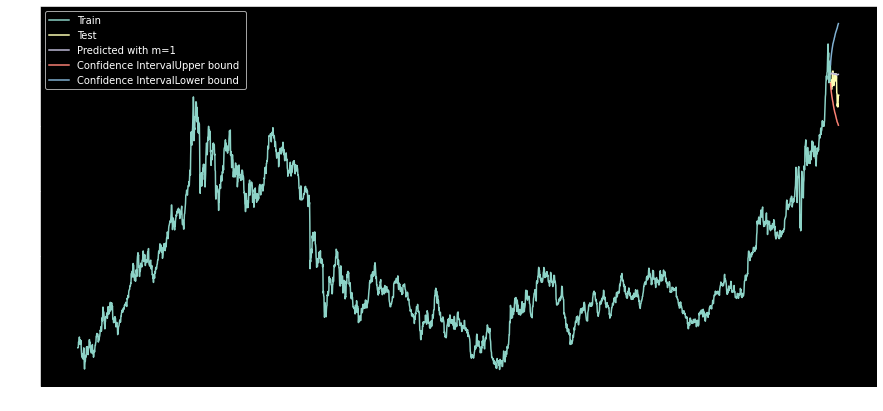

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 1


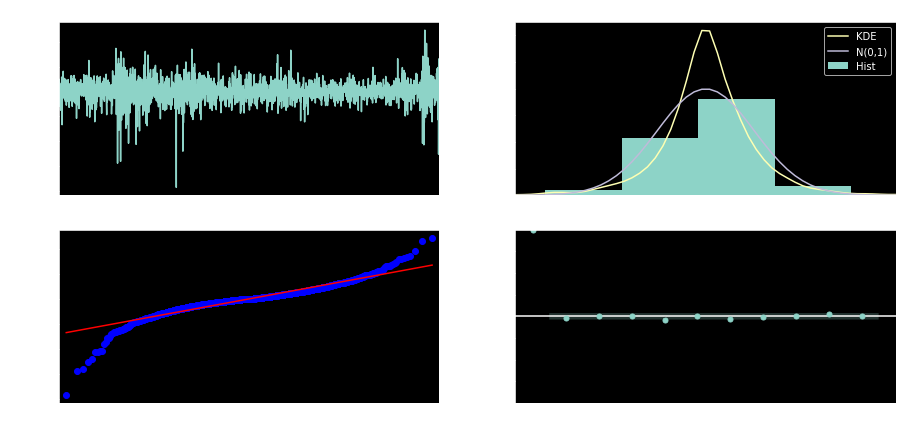

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 4
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=22724.853, Time=4.58 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=22724.202, Time=0.36 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=22721.000, Time=1.27 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=22720.992, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=22723.295, Time=1.36 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=22725.198, Time=0.69 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=22722.987, Time=4.86 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=22722.988, Time=2.86 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=22721.017, Time=1.89 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=22724.991, Time=4.14 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=22719.984, Time=1.45 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=22721.972, Time=3.28 sec
 ARIMA(0,1

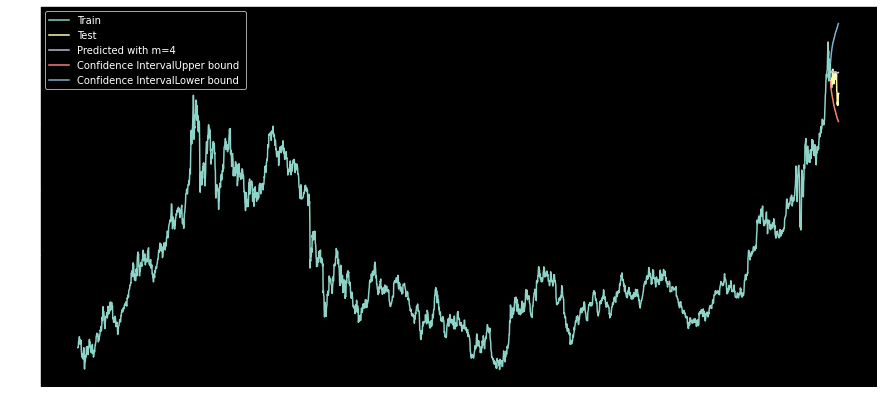

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 4


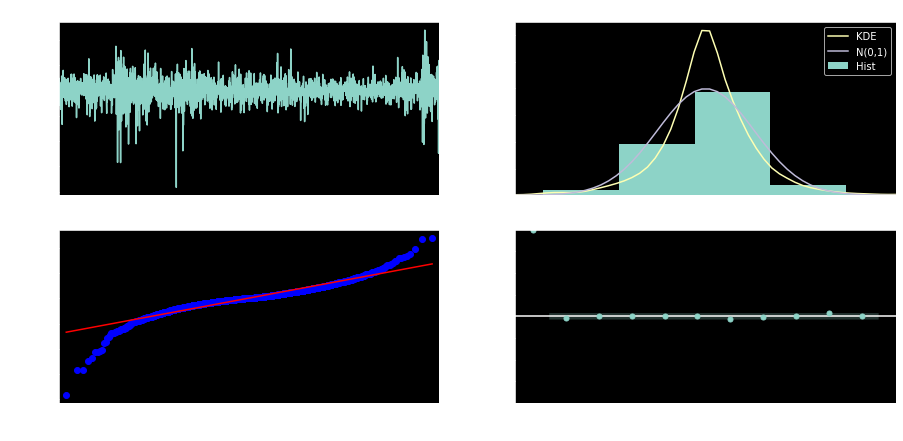

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 7
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=22729.676, Time=13.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=22724.202, Time=0.37 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=22727.015, Time=1.31 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=22727.028, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=22723.295, Time=1.22 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=22726.070, Time=1.18 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=22726.064, Time=0.90 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=22726.417, Time=4.98 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=22725.178, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=22725.198, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=22727.084, Time=2.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 28.712 second

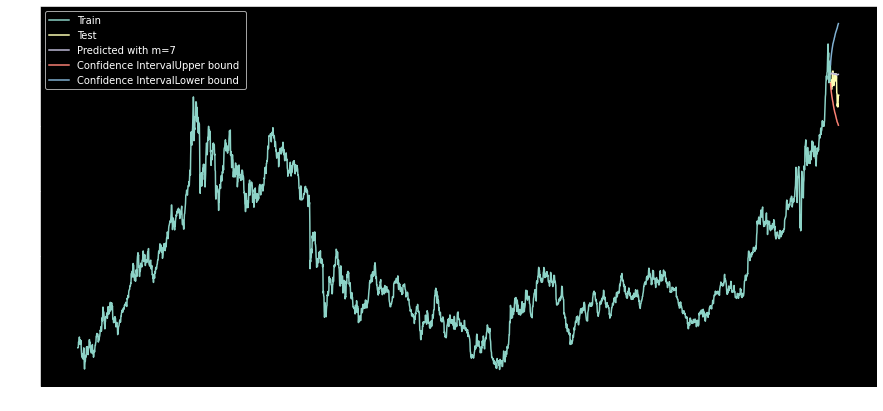

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 7


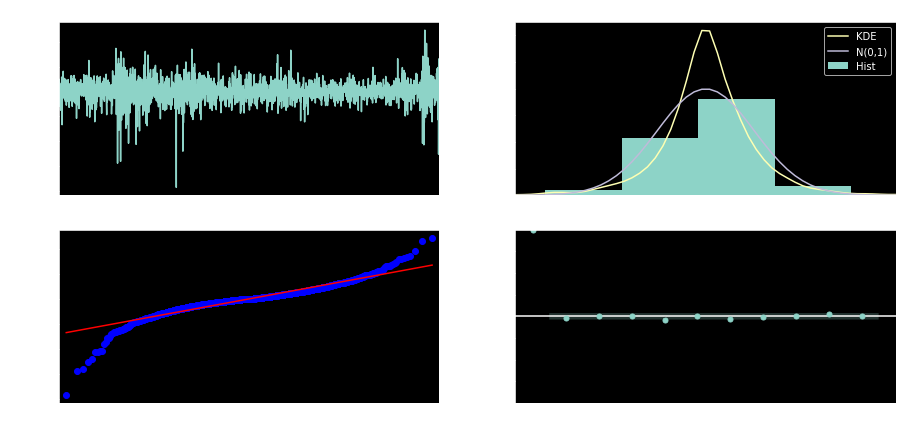

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 12
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=22731.064, Time=10.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=22724.202, Time=0.37 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=22727.170, Time=1.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=22727.189, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=22723.295, Time=1.17 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=22726.184, Time=1.11 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=22726.183, Time=1.13 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=22728.195, Time=1.44 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=22725.178, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=22725.198, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=22727.084, Time=3.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 

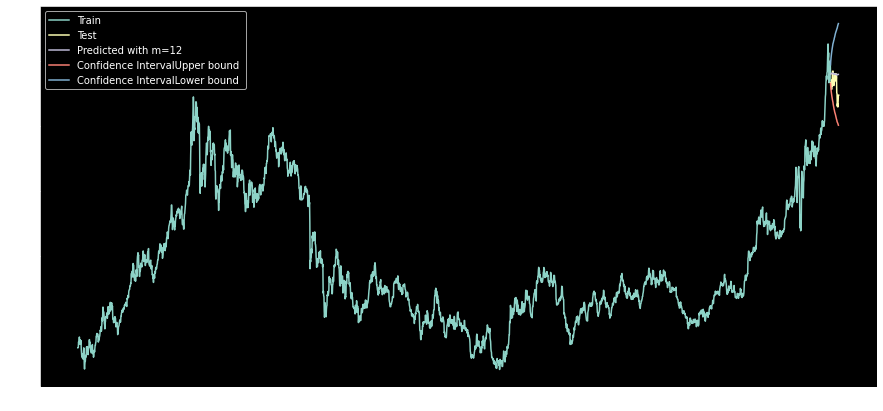

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 12


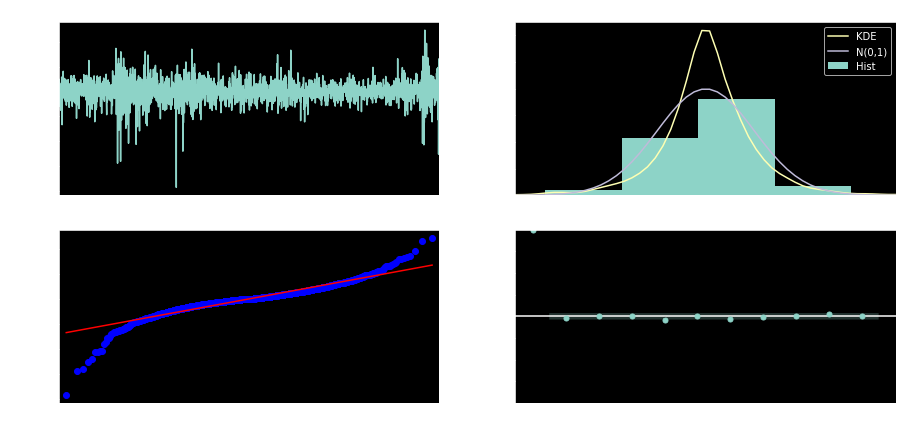

----------------------------------------------------------------------------------------------------
 Fitting SARIMAX for Seasonal value m = 52
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=22729.655, Time=2338.92 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=22724.202, Time=1.07 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=22727.005, Time=40.06 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=22727.037, Time=88.10 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=22723.295, Time=1.98 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=22726.053, Time=27.59 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=22726.063, Time=29.42 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=22726.822, Time=68.20 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=22725.178, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=22725.198, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=22727.084, Time=1.92 sec

Best model:  ARIMA(0,1,0)(0,0,0)[52]          
Total fit

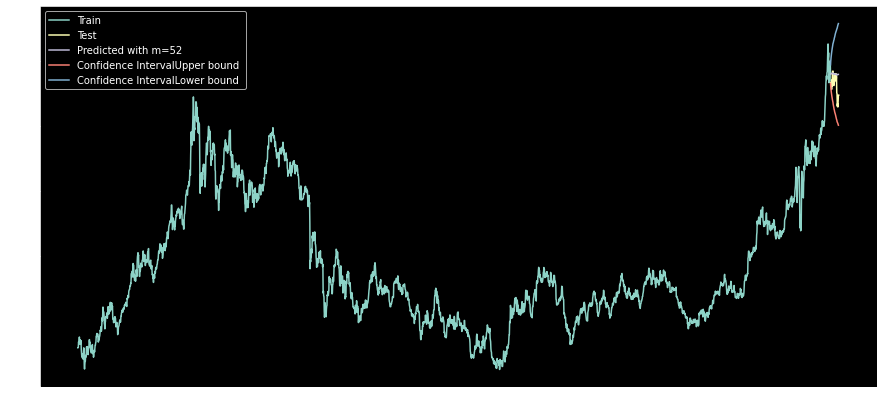

----------------------------------------------------------------------------------------------------
 Diagnostic plot for Seasonal value m = 52


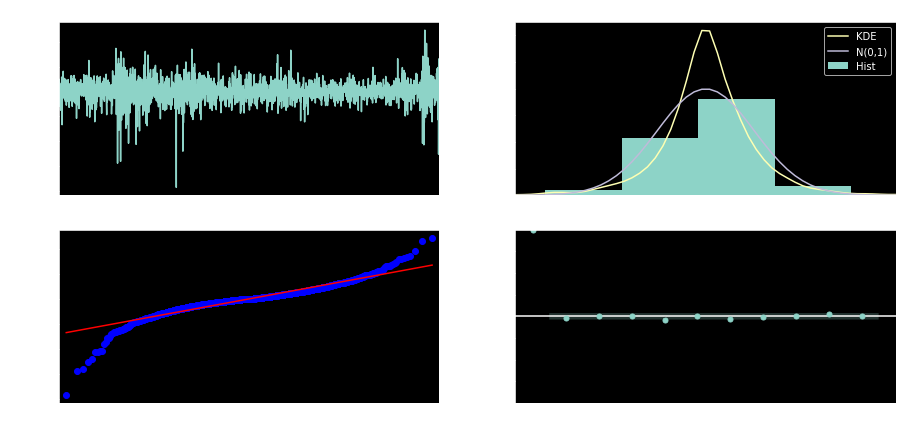

----------------------------------------------------------------------------------------------------


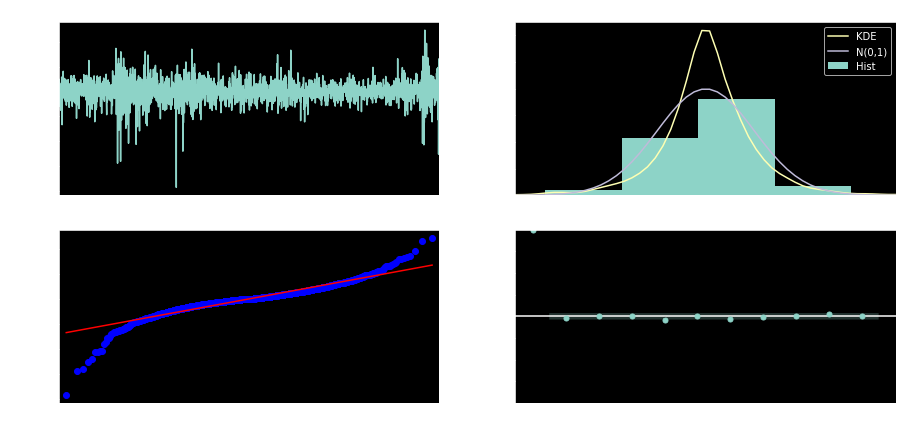

In [36]:
# Let’s configure and run seasonal arima with an exogenous variable.

for m in [1, 4,7,12,52]:
    print("="*100)
    print(f' Fitting SARIMAX for Seasonal value m = {str(m)}')
    stepwise_model = auto_arima(actualtrain,exogenous =exotrain ,
                                start_p=1, start_q=1,max_p=7, max_q=7, seasonal=True,
                                start_P=1,start_Q=1,max_P=7,max_D=7,max_Q=7,m=m, d=None,D=None,
                                trace=True,error_action='ignore',suppress_warnings=True,
                                stepwise=True)
    print(f'Model summary for m = {str(m)}')
    print("-"*100)
    stepwise_model.summary()
    
    forecast,conf_int = stepwise_model.predict(n_periods=30,
                                               exogenous =exotest,return_conf_int=True)
    df_conf = pd.DataFrame(conf_int,columns= ['Upper_bound','Lower_bound'])
    df_conf["new_index"] = range(2773, 2803)
    df_conf = df_conf.set_index("new_index")
    forecast = pd.DataFrame(forecast, columns=['close_pred'])
    forecast["new_index"] = range(2773, 2803)
    forecast = forecast.set_index("new_index")
    timeseries_evaluation_metrics_func(actualtest, forecast)
    
    get_ipython().run_line_magic('matplotlib', 'inline')
    plt.rcParams["figure.figsize"] = [15, 7]
    plt.plot(actualtrain, label='Train ')
    plt.plot(actualtest, label='Test ')
    plt.plot(forecast, label=f'Predicted with m={str(m)} ')
    plt.plot(df_conf['Upper_bound'], label='Confidence IntervalUpper bound ')
    plt.plot(df_conf['Lower_bound'], label='Confidence IntervalLower bound ')
    plt.legend(loc='best')
    plt.show()
    print("-"*100)
    print(f' Diagnostic plot for Seasonal value m = {str(m)}')
    display(stepwise_model.plot_diagnostics());
    print("-"*100)

We can see that the exogenous variable S&P500 is not contributing to model accuracy, and we notice that m does not have any
influence on prediction.